# 🤖 ADK: ¡Crea Equipos de Agentes! Orquestación y Flujos de Trabajo (Clase 5)

## 📚 Introducción

En esta clase aprenderás a:
- Coordinar múltiples agentes para ejecutar tareas complejas
- Usar agentes de flujo de trabajo (SequentialAgent, ParallelAgent, LoopAgent)
- Implementar enrutamiento dinámico con agentes gerentes
- Construir un sistema multiagente completo

## 🛠️ Instalación y Setup

### Instalación del ADK

In [14]:
# Instalar Google ADK
!pip install -q google-adk==1.4.2

In [2]:
# Importar las librerías necesarias
import os
import logging
from typing_extensions import override

# ADK imports
from google.adk.agents import (
    LlmAgent, 
    SequentialAgent, 
    ParallelAgent, 
    LoopAgent
    )
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types

#### Opcion 1: Ingresalas directamente

In [ ]:
from getpass import getpass
# Solicitar API Key de forma segura
if 'GOOGLE_API_KEY' not in os.environ:
    print("🔑 Por favor, ingresa tu Google API Key:")
    api_key = getpass("API Key: ")
    os.environ['GOOGLE_API_KEY'] = api_key
    os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'FALSE'
    print("\n✅ API Key configurada correctamente")
else:
    print("✅ API Key ya configurada")

# Verificar que las variables estén configuradas
print(f"\n📋 Variables de entorno configuradas:")
print(f"   - GOOGLE_API_KEY: {'✓' if os.environ.get('GOOGLE_API_KEY') else '✗'}")
print(f"   - GOOGLE_GENAI_USE_VERTEXAI: {os.environ.get('GOOGLE_GENAI_USE_VERTEXAI', 'No configurado')}")

print("✅ ADK instalado y configurado correctamente!")

#### Opcion 2: Cargar por Dotenv

In [3]:
from dotenv import load_dotenv
# Cargar variables de entorno desde .env si existe
load_dotenv(override=True)

True

#### Nuestra función de inferencia

In [4]:
async def call_agent_async_with_full_trace(query: str, runner, user_id, session_id):
    """Envía una consulta al agente e imprime la respuesta final y la traza de cada paso."""
    print(f"\n>>> Consulta del usuario: {query}")
    print("--- Iniciando el pipeline de procesamiento de datos ---")

    content = types.Content(role='user', parts=[types.Part(text=query)])
    final_response_text = "El agente no produjo una respuesta final."

    # Itera a través de *todos* los eventos del pipeline para ver la traza completa.
    # NO uses 'break' dentro de este bucle.
    async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
        # Imprime cada evento que tenga contenido de texto para ver la traza.
        if event.content and event.content.parts and event.content.parts[0].text:
            # Incluyo el 'Autor' (nombre del agente) y el 'Tipo' de evento para mayor claridad.
            print(f"----->>> [Evento] Autor: {event.author}, Tipo: {type(event).__name__}, Contenido: '{event.content.parts[0].text}'")

        # Captura la respuesta final cuando el SequentialAgent termina.
        # Esta lógica se ejecuta en cada evento, asegurando que se guarda la última respuesta.
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response_text = event.content.parts[0].text

    print("--- Finalizando el pipeline de procesamiento de datos ---")
    print(f"\n<<< Respuesta final del agente: {final_response_text}")

## 🎯 Parte 1: ¿Qué es la Orquestación de Agentes?

La orquestación de agentes es el arte de **coordinar múltiples agentes especializados** para lograr objetivos complejos. En lugar de un agente monolítico, dividimos el problema en subtareas manejables.

### Ventajas de la Orquestación:
- **Modularidad**: Agentes más simples y fáciles de mantener
- **Reutilización**: Los especialistas se pueden usar en diferentes flujos
- **Escalabilidad**: Añadir nuevos especialistas sin modificar los existentes
- **Optimización**: Usar el modelo LLM más adecuado para cada tarea

## 🔄 Parte 2: Agentes de Flujo de Trabajo (Workflow Agents)

ADK proporciona tres tipos principales de agentes de flujo de trabajo:

### 2.1 SequentialAgent - Ejecución Secuencial

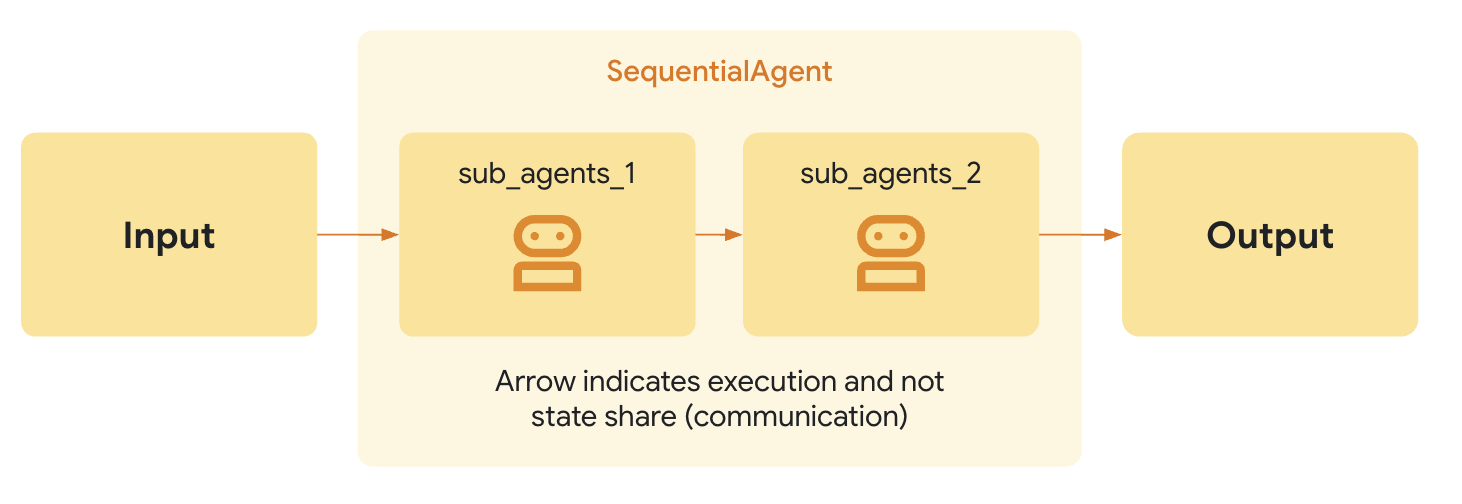

In [9]:
# --- 1. Definir Sub-Agentes para Cada Etapa del Pipeline ---
GEMINI_MODEL = "gemini-2.5-flash"  # Modelo de Gemini a utilizar
# Agente Extractor de Información
# Toma el documento inicial (de la consulta del usuario) y extrae información clave.
extractor_agent = LlmAgent(
    name="ExtractorAgent",
    model=GEMINI_MODEL,
    instruction="""Eres un Especialista en Extracción de Información de Documentos.
Basándote *únicamente* en el documento proporcionado por el usuario, extrae la información más importante y relevante.

**Tu tarea:**
1. Identifica los puntos clave, datos importantes, fechas, nombres, cifras, y conceptos principales
2. Organiza la información extraída de manera clara y estructurada
3. Mantén la objetividad y no agregues interpretaciones personales

**Formato de salida:**
Presenta la información extraída en categorías claras como:
- Información General
- Datos Numéricos/Estadísticas  
- Personas/Entidades Mencionadas
- Fechas Importantes
- Puntos Clave del Contenido

Proporciona *solo* la información extraída de forma organizada, sin comentarios adicionales.""",
    description="Extrae información clave y datos importantes de documentos.",
    output_key="informacion_extraida" # Almacena salida en state['informacion_extraida']
)

# Agente Analizador de Contenido
# Toma la información extraída por el agente anterior y proporciona análisis profundo.
analizador_agent = LlmAgent(
    name="AnalizadorAgent", 
    model=GEMINI_MODEL,
    instruction="""Eres un Analista Experto de Contenido.
Tu tarea es analizar profundamente la información extraída y generar insights valiosos.

**Información a Analizar:**
{informacion_extraida}

**Criterios de Análisis:**
1. **Tendencias y Patrones:** ¿Qué tendencias o patrones emergen de los datos?
2. **Implicaciones:** ¿Cuáles son las implicaciones más importantes de esta información?
3. **Relaciones:** ¿Cómo se relacionan entre sí los diferentes elementos?
4. **Oportunidades:** ¿Qué oportunidades o riesgos se pueden identificar?
5. **Context:** ¿Qué significa esta información en el contexto más amplio?

**Salida:**
Proporciona un análisis estructurado con insights claros y accionables.
Enfócate en los hallazgos más significativos que agreguen valor al documento original.
Presenta *solo* el análisis sin comentarios adicionales.""",
    description="Analiza información extraída para generar insights valiosos.",
    output_key="analisis_insights" # Almacena salida en state['analisis_insights']
)

# Agente Creador de Posts para LinkedIn
# Toma la información extraída y el análisis para crear posts atractivos para LinkedIn.
creador_linkedin_agent = LlmAgent(
    name="CreadorLinkedInAgent",
    model=GEMINI_MODEL,
    instruction="""Eres un Especialista en Marketing de Contenido para LinkedIn.
Tu objetivo es crear posts atractivos y profesionales para LinkedIn basados en la información y análisis proporcionados.

**Información Extraída:**
{informacion_extraida}

**Análisis e Insights:**
{analisis_insights}

**Tarea:**
Crea un post para LinkedIn que sea:
1. **Atractivo:** Que capture la atención desde las primeras líneas
2. **Profesional:** Mantén un tono apropiado para la red profesional
3. **Valioso:** Que aporte insights útiles a la audiencia
4. **Accionable:** Que incluya llamadas a la acción relevantes
5. **Engaging:** Que fomente la interacción y comentarios

**Estructura del Post:**
- Hook inicial impactante (1-2 líneas)
- Desarrollo del insight principal (3-4 párrafos cortos)
- 3-5 puntos clave con emojis apropiados
- Llamada a la acción final
- Hashtags relevantes (5-8 hashtags)

**Estilo:**
- Usa párrafos cortos para facilitar lectura
- Incluye emojis estratégicamente
- Mantén un tono conversacional pero profesional
- Longitud ideal: 200-300 palabras

**Salida:**
Proporciona *únicamente* el post final listo para publicar en LinkedIn.""",
    description="Crea posts atractivos para LinkedIn basados en extracción y análisis de documentos.",
    output_key="post_linkedin" # Almacena salida en state['post_linkedin']
)

# --- 2. Crear el SequentialAgent ---
# Este agente orquesta el pipeline ejecutando los sub_agents en orden.
pipeline_analisis_documentos = SequentialAgent(
    name="PipelineAnalisisDocumentos",
    sub_agents=[extractor_agent, analizador_agent, creador_linkedin_agent],
    description="Ejecuta una secuencia de extracción, análisis y creación de posts para LinkedIn basados en documentos.",
    # Los agentes se ejecutarán en el orden proporcionado: Extractor -> Analizador -> Creador LinkedIn
)

In [11]:

session_service = InMemorySessionService()

APP_NAME = "sequence_agent_example"
USER_ID = "user_1"
SESSION_ID = "session_001" # Usando un ID fijo por simplicidad

# Crear la sesión específica donde ocurrirá la conversación
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
# Runner: Este es el componente principal que gestiona la interacción con el agente.
runner = Runner(agent=pipeline_analisis_documentos,
                app_name=APP_NAME,
                session_service=session_service)


In [12]:
# Texto de prueba
texto_entrada = """
Introducing a new, unifying DNA sequence model that advances regulatory variant-effect prediction and promises to shed new light on genome function — now available via API.

The genome is our cellular instruction manual. It’s the complete set of DNA which guides nearly every part of a living organism, from appearance and function to growth and reproduction. Small variations in a genome’s DNA sequence can alter an organism’s response to its environment or its susceptibility to disease. But deciphering how the genome’s instructions are read at the molecular level — and what happens when a small DNA variation occurs — is still one of biology’s greatest mysteries.

Today, we introduce AlphaGenome, a new artificial intelligence (AI) tool that more comprehensively and accurately predicts how single variants or mutations in human DNA sequences impact a wide range of biological processes regulating genes. This was enabled, among other factors, by technical advances allowing the model to process long DNA sequences and output high-resolution predictions.

To advance scientific research, we’re making AlphaGenome available in preview via our AlphaGenome API for non-commercial research, and planning to release the model in the future.

We believe AlphaGenome can be a valuable resource for the scientific community, helping scientists better understand genome function, disease biology, and ultimately, drive new biological discoveries and the development of new treatments.

How AlphaGenome works
Our AlphaGenome model takes a long DNA sequence as input — up to 1 million letters, also known as base-pairs — and predicts thousands of molecular properties characterising its regulatory activity. It can also score the effects of genetic variants or mutations by comparing predictions of mutated sequences with unmutated ones.

Predicted properties include where genes start and where they end in different cell types and tissues, where they get spliced, the amount of RNA being produced, and also which DNA bases are accessible, close to one another, or bound by certain proteins. Training data was sourced from large public consortia including ENCODE, GTEx, 4D Nucleome and FANTOM5, which experimentally measured these properties covering important modalities of gene regulation across hundreds of human and mouse cell types and tissues.


Play video
Animation showing AlphaGenome taking one million DNA letters as input and predicting diverse molecular properties across different tissues and cell types.

The AlphaGenome architecture uses convolutional layers to initially detect short patterns in the genome sequence, transformers to communicate information across all positions in the sequence, and a final series of layers to turn the detected patterns into predictions for different modalities. During training, this computation is distributed across multiple interconnected Tensor Processing Units (TPUs) for a single sequence.

This model builds on our previous genomics model, Enformer and is complementary to AlphaMissense, which specializes in categorizing the effects of variants within protein-coding regions. These regions cover 2% of the genome. The remaining 98%, called non-coding regions, are crucial for orchestrating gene activity and contain many variants linked to diseases. AlphaGenome offers a new perspective for interpreting these expansive sequences and the variants within them.

AlphaGenome’s distinctive features
AlphaGenome offers several distinctive features compared to existing DNA sequence models:

Long sequence-context at high resolution
Our model analyzes up to 1 million DNA letters and makes predictions at the resolution of individual letters. Long sequence context is important for covering regions regulating genes from far away and base-resolution is important for capturing fine-grained biological details.

Previous models had to trade off sequence length and resolution, which limited the range of modalities they could jointly model and accurately predict. Our technical advances address this limitation without significantly increasing the training resources — training a single AlphaGenome model (without distillation) took four hours and required half of the compute budget used to train our original Enformer model.

Comprehensive multimodal prediction
By unlocking high resolution prediction for long input sequences, AlphaGenome can predict the most diverse range of modalities. In doing so, AlphaGenome provides scientists with more comprehensive information about the complex steps of gene regulation.

Efficient variant scoring
In addition to predicting a diverse range of molecular properties, AlphaGenome can efficiently score the impact of a genetic variant on all of these properties in a second. It does this by contrasting predictions of mutated sequences with unmutated ones, and efficiently summarising that contrast using different approaches for different modalities.

Novel splice-junction modeling
Many rare genetic diseases, such as spinal muscular atrophy and some forms of cystic fibrosis, can be caused by errors in RNA splicing — a process where parts of the RNA molecule are removed, or “spliced out”, and the remaining ends rejoined. For the first time, AlphaGenome can explicitly model the location and expression level of these junctions directly from sequence, offering deeper insights about the consequences of genetic variants on RNA splicing.

State-of-the-art performance across benchmarks
AlphaGenome achieves state-of-the-art performance across a wide range of genomic prediction benchmarks, such as predicting which parts of the DNA molecule will be in close proximity, whether a genetic variant will increase or decrease expression of a gene, or whether it will change the gene’s splicing pattern.


Bar graph showing AlphaGenome’s relative improvements on selected DNA sequence and variant effect tasks, compared against results for the current best methods in each category.

When producing predictions for single DNA sequences, AlphaGenome outperformed the best external models on 22 out of 24 evaluations. And when predicting the regulatory effect of a variant, it matched or exceeded the top-performing external models on 24 out of 26 evaluations.

This comparison included models specialized for individual tasks. AlphaGenome was the only model that could jointly predict all of the assessed modalities, highlighting its generality. Read more in our preprint.

The benefits of a unifying model
AlphaGenome’s generality allows scientists to simultaneously explore a variant's impact on a number of modalities with a single API call. This means that scientists can generate and test hypotheses more rapidly, without having to use multiple models to investigate different modalities.

Moreover AlphaGenome’s strong performance indicates it has learned a relatively general representation of DNA sequence in the context of gene regulation. This makes it a strong foundation for the wider community to build upon. Once the model is fully released, scientists will be able to adapt and fine-tune it on their own datasets to better tackle their unique research questions.

Finally, this approach provides a flexible and scalable architecture for the future. By extending the training data, AlphaGenome’s capabilities could be extended to yield better performance, cover more species, or include additional modalities to make the model even more comprehensive.

“
It’s a milestone for the field. For the first time, we have a single model that unifies long-range context, base-level precision and state-of-the-art performance across a whole spectrum of genomic tasks.

Dr. Caleb Lareau, Memorial Sloan Kettering Cancer Center

A powerful research tool
AlphaGenome's predictive capabilities could help several research avenues:

Disease understanding: By more accurately predicting genetic disruptions, AlphaGenome could help researchers pinpoint the potential causes of disease more precisely, and better interpret the functional impact of variants linked to certain traits, potentially uncovering new therapeutic targets. We think the model is especially suitable for studying rare variants with potentially large effects, such as those causing rare Mendelian disorders.
Synthetic biology: Its predictions could be used to guide the design of synthetic DNA with specific regulatory function — for example, only activating a gene in nerve cells but not muscle cells.
Fundamental research: It could accelerate our understanding of the genome by assisting in mapping its crucial functional elements and defining their roles, identifying the most essential DNA instructions for regulating a specific cell type's function.
For example, we used AlphaGenome to investigate the potential mechanism of a cancer-associated mutation. In an existing study of patients with T-cell acute lymphoblastic leukemia (T-ALL), researchers observed mutations at particular locations in the genome. Using AlphaGenome, we predicted that the mutations would activate a nearby gene called TAL1 by introducing a MYB DNA binding motif, which replicated the known disease mechanism and highlighted AlphaGenome’s ability to link specific non-coding variants to disease genes.

“
AlphaGenome will be a powerful tool for the field. Determining the relevance of different non-coding variants can be extremely challenging, particularly to do at scale. This tool will provide a crucial piece of the puzzle, allowing us to make better connections to understand diseases like cancer.

Professor Marc Mansour, University College London

Current limitations
AlphaGenome marks a significant step forward, but it's important to acknowledge its current limitations.

Like other sequence-based models, accurately capturing the influence of very distant regulatory elements, like those over 100,000 DNA letters away, is still an ongoing challenge. Another priority for future work is further increasing the model’s ability to capture cell- and tissue-specific patterns.

We haven't designed or validated AlphaGenome for personal genome prediction, a known challenge for AI models. Instead, we focused more on characterising the performance on individual genetic variants. And while AlphaGenome can predict molecular outcomes, it doesn't give the full picture of how genetic variations lead to complex traits or diseases. These often involve broader biological processes, like developmental and environmental factors, that are beyond the direct scope of our model.

We’re continuing to improve our models and gathering feedback to help us address these gaps."""

# Ejecutar

await call_agent_async_with_full_trace(texto_entrada,
                        runner=runner,
                        user_id=USER_ID,
                        session_id=SESSION_ID)



>>> Consulta del usuario: 
Introducing a new, unifying DNA sequence model that advances regulatory variant-effect prediction and promises to shed new light on genome function — now available via API.

The genome is our cellular instruction manual. It’s the complete set of DNA which guides nearly every part of a living organism, from appearance and function to growth and reproduction. Small variations in a genome’s DNA sequence can alter an organism’s response to its environment or its susceptibility to disease. But deciphering how the genome’s instructions are read at the molecular level — and what happens when a small DNA variation occurs — is still one of biology’s greatest mysteries.

Today, we introduce AlphaGenome, a new artificial intelligence (AI) tool that more comprehensively and accurately predicts how single variants or mutations in human DNA sequences impact a wide range of biological processes regulating genes. This was enabled, among other factors, by technical advances 

### 2.2 ParallelAgent - Ejecución en Paralelo

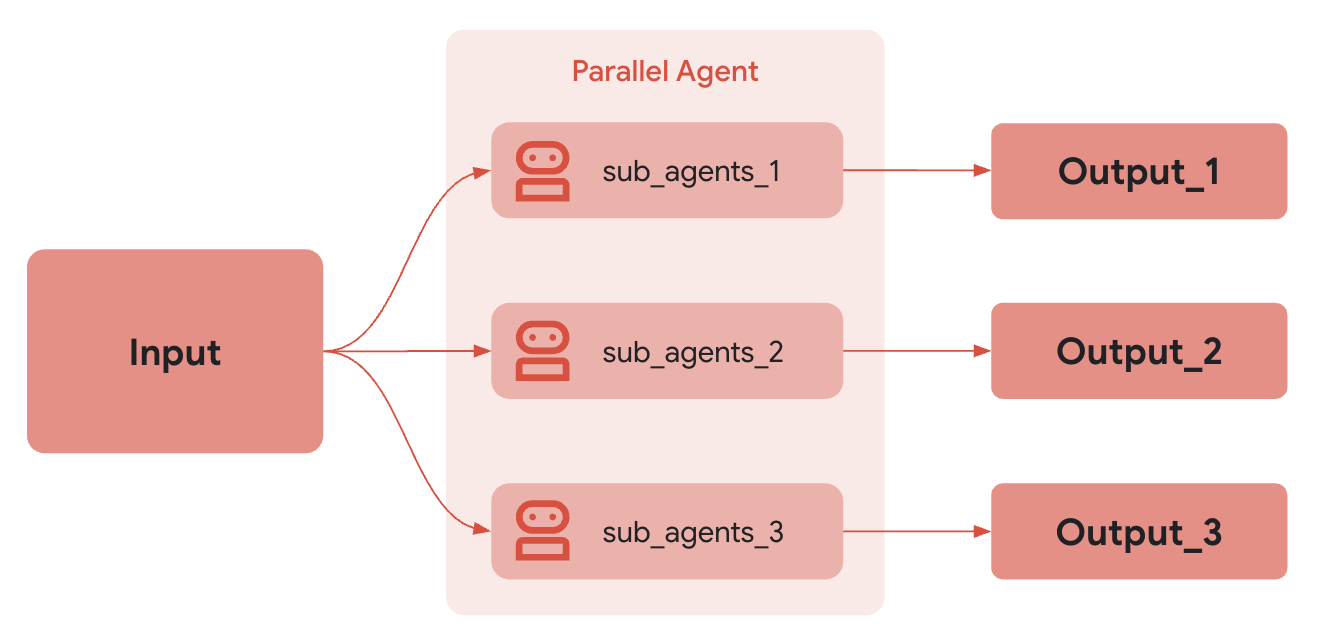

In [16]:
from google.adk.tools import google_search
GEMINI_MODEL = "gemini-2.5-flash"
# Ejemplo 2: Investigación en Paralelo
print("\n=== Ejemplo: ParallelAgent ===")
# Parte de agent.py --> Sigue https://google.github.io/adk-docs/get-started/quickstart/ para aprender la configuración
# --- 1. Definir Sub-Agentes Investigadores (para ejecutar en paralelo) ---

# Investigador 1: Tendencias de Consumo
investigador_consumo = LlmAgent(
    name="InvestigadorTendenciasConsumo",
    model=GEMINI_MODEL,
    instruction="""Eres un Asistente de Investigación de IA especializado en comportamiento del consumidor.
Investiga las últimas 'tendencias de consumo en e-commerce' y patrones de compra online.
Utiliza la herramienta Google Search proporcionada.
Resume tus hallazgos clave de forma concisa.
Proporciona *únicamente* el resumen.
""",
    description="Investiga tendencias de consumo y patrones de compra en e-commerce.",
    tools=[google_search],
    # Almacena resultado en state para el agente fusionador
    output_key="tendencias_consumo_resultado"
)

# Investigador 2: Análisis de Competidores
investigador_competidores = LlmAgent(
    name="InvestigadorCompetidores",
    model=GEMINI_MODEL,
    instruction="""Eres un Asistente de Investigación de IA especializado en análisis competitivo.
Investiga los 'principales competidores en e-commerce' y sus estrategias exitosas.
Utiliza la herramienta Google Search proporcionada.
Resume tus hallazgos clave de forma concisa.
Proporciona *únicamente* el resumen.
""",
    description="Investiga competidores principales y estrategias exitosas en e-commerce.",
    tools=[google_search],
    # Almacena resultado en state para el agente fusionador
    output_key="competidores_resultado"
)

# Investigador 3: Tecnologías Emergentes
investigador_tecnologias = LlmAgent(
    name="InvestigadorTecnologias",
    model=GEMINI_MODEL,
    instruction="""Eres un Asistente de Investigación de IA especializado en tecnología retail.
Investiga las 'tecnologías emergentes en e-commerce' como IA, AR/VR, y automatización.
Utiliza la herramienta Google Search proporcionada.
Resume tus hallazgos clave de forma concisa.
Proporciona *únicamente* el resumen.
""",
    description="Investiga tecnologías emergentes y innovaciones en e-commerce.",
    tools=[google_search],
    # Almacena resultado en state para el agente fusionador
    output_key="tecnologias_resultado"
)

# --- 2. Crear el ParallelAgent (Ejecuta investigadores concurrentemente) ---
# Este agente orquesta la ejecución concurrente de los investigadores.
# Termina una vez que todos los investigadores han completado y almacenado sus resultados en state.
agente_investigacion_paralela = ParallelAgent(
    name="AgenteInvestigacionEcommerceParalela",
    sub_agents=[investigador_consumo, investigador_competidores, investigador_tecnologias],
    description="Ejecuta múltiples agentes de investigación en paralelo para recopilar información de mercado."
)

# --- 3. Definir el Agente Fusionador (Se ejecuta *después* de los agentes paralelos) ---
# Este agente toma los resultados almacenados en el estado de sesión por los agentes paralelos
# y los sintetiza en una respuesta única y estructurada con atribuciones.
agente_fusionador = LlmAgent(
    name="AgenteSintesis",
    model=GEMINI_MODEL,  # O potencialmente un modelo más potente si es necesario para síntesis
    instruction="""Eres un Asistente de IA responsable de combinar hallazgos de investigación en un reporte estructurado de mercado.

Tu tarea principal es sintetizar los siguientes resúmenes de investigación, atribuyendo claramente los hallazgos a sus áreas fuente. Estructura tu respuesta usando encabezados para cada tema. Asegúrate de que el reporte sea coherente e integre los puntos clave de manera fluida.

**Crucial: Tu respuesta completa DEBE estar basada *exclusivamente* en la información proporcionada en los 'Resúmenes de Entrada' a continuación. NO agregues conocimiento externo, hechos o detalles que no estén presentes en estos resúmenes específicos.**

**Resúmenes de Entrada:**

*   **Tendencias de Consumo:**
    {tendencias_consumo_resultado}

*   **Análisis de Competidores:**
    {competidores_resultado}

*   **Tecnologías Emergentes:**
    {tecnologias_resultado}

**Formato de Salida:**

## Análisis de Mercado E-commerce: Hallazgos Recientes

### Tendencias de Consumo
(Basado en hallazgos del InvestigadorTendenciasConsumo)
[Sintetiza y elabora *únicamente* sobre el resumen de entrada de tendencias de consumo proporcionado arriba.]

### Panorama Competitivo
(Basado en hallazgos del InvestigadorCompetidores)
[Sintetiza y elabora *únicamente* sobre el resumen de entrada de competidores proporcionado arriba.]

### Innovaciones Tecnológicas
(Basado en hallazgos del InvestigadorTecnologias)
[Sintetiza y elabora *únicamente* sobre el resumen de entrada de tecnologías proporcionado arriba.]

### Conclusión General
[Proporciona una breve declaración concluyente (1-2 oraciones) que conecte *únicamente* los hallazgos presentados arriba.]

Proporciona *únicamente* el reporte estructurado siguiendo este formato. No incluyas frases introductorias o conclusivas fuera de esta estructura, y adhiérete estrictamente a usar solo el contenido de los resúmenes de entrada proporcionados.
""",
    description="Combina hallazgos de investigación de agentes paralelos en un reporte estructurado y citado, estrictamente basado en las entradas proporcionadas.",
    # No se necesitan herramientas para fusionar
    # No se necesita output_key aquí, ya que su respuesta directa es la salida final de la secuencia
)

# --- 4. Crear el SequentialAgent (Orquesta el flujo general) ---
# Este es el agente principal que se ejecutará. Primero ejecuta el ParallelAgent
# para poblar el estado, y luego ejecuta el AgenteFusionador para producir la salida final.
agente_pipeline_secuencial = SequentialAgent(
    name="PipelineInvestigacionYSintesis",
    # Ejecuta investigación paralela primero, luego fusiona
    sub_agents=[agente_investigacion_paralela, agente_fusionador],
    description="Coordina investigación paralela y sintetiza los resultados en análisis de mercado."
)



=== Ejemplo: ParallelAgent ===


In [17]:

session_service = InMemorySessionService()

APP_NAME = "parallel_agent_example"
USER_ID = "user_1"
SESSION_ID = "session_001" # Usando un ID fijo por simplicidad

# Crear la sesión específica donde ocurrirá la conversación
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
# Runner: Este es el componente principal que gestiona la interacción con el agente.
runner = Runner(agent=agente_pipeline_secuencial,
                app_name=APP_NAME,
                session_service=session_service)



In [18]:
# Texto de prueba
texto_entrada = """Investiga las últimas tendencias de  e-commerce.
Proporciona un análisis de mercado completo y estructurado basado en la información recopilada.
"""

# Ejecutar

await call_agent_async_with_full_trace(texto_entrada,
                        runner=runner,
                        user_id=USER_ID,
                        session_id=SESSION_ID)



>>> Consulta del usuario: Investiga las últimas tendencias de  e-commerce.
Proporciona un análisis de mercado completo y estructurado basado en la información recopilada.

--- Iniciando el pipeline de procesamiento de datos ---
----->>> [Evento] Autor: InvestigadorTendenciasConsumo, Tipo: Event, Contenido: 'El mercado del e-commerce se encuentra en una evolución constante, impulsado por avances tecnológicos y cambios en el comportamiento del consumidor. Para 2024 y 2025, las tendencias clave se centran en la personalización, la integración de canales y la aplicación de nuevas tecnologías.

**1. Experiencia del Cliente y Personalización:**
*   **Personalización Avanzada:** Los consumidores esperan experiencias de compra altamente personalizadas, desde recomendaciones de productos hasta precios dinámicos adaptados a su comportamiento. La inteligencia artificial (IA) es fundamental para lograr esta personalización, con el 75% de las empresas que la implementan esperando un aumento signif

### 2.3 LoopAgent - Ejecución Iterativa

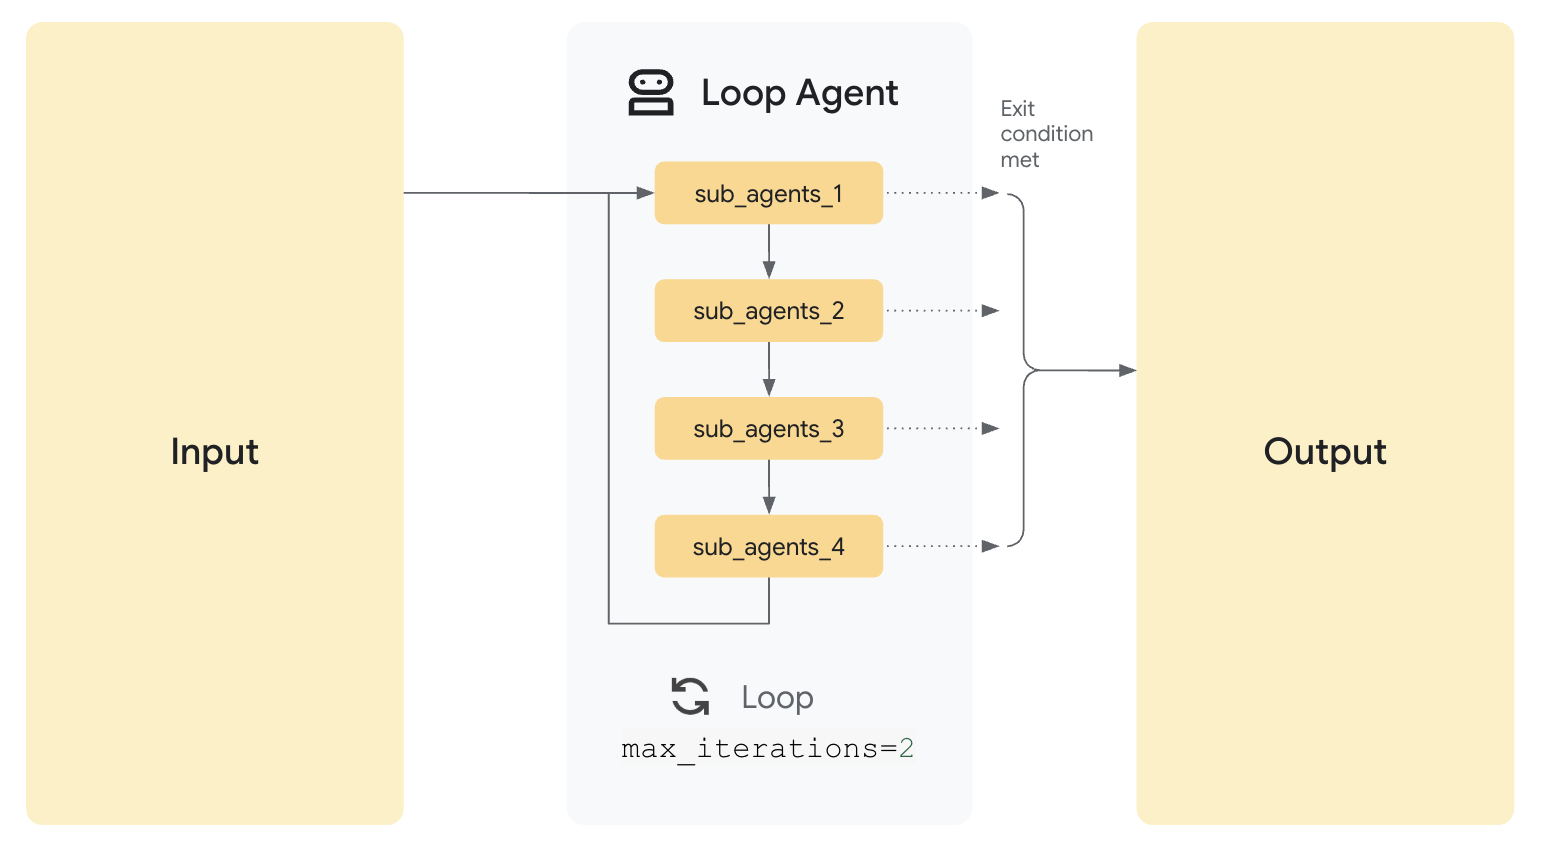

In [20]:
from google.adk.tools.tool_context import ToolContext

In [21]:
# Ejemplo 3: Refinamiento Iterativo de Contenido

# Herramienta para salir del loop
def exit_loop(tool_context: ToolContext):
  """Call this function ONLY when the critique indicates no further changes are needed, signaling the iterative process should end."""
  print(f"  [Tool Call] exit_loop triggered by {tool_context.agent_name}")
  tool_context.actions.escalate = True
  # Return empty dict as tools should typically return JSON-serializable output
  return {}

print("\n=== Ejemplo: LoopAgent ===")

# Agente escritor
escritor = LlmAgent(
    name="Escritor",
    model="gemini-1.5-flash",
    instruction=(
        "Mejora el texto actual basándote en las críticas recibidas. "
        "Si no hay texto previo, genera uno inicial sobre el tema dado."
    ),
    output_key="texto_actual"
)

# Agente crítico
critico = LlmAgent(
    name="Critico",
    model="gemini-2.5-flash",
    instruction=(
        "Revisa de manera muy detallada y critica el siguiente texto 'texto_actual'"
        "y proporciona críticas constructivas para mejorarlo. "
        "Dado el caso que el texto sea excelente y no necesite de ninguna mejora, di exactamente: "
        "'No se requieren más mejoras.' y llama a la herramienta exit_loop. "
        "De lo contrario, proporciona sugerencias específicas para mejorar el texto."
    ),
    tools=[exit_loop],
    output_key="critica"
)


# Loop de refinamiento
loop_refinamiento = LoopAgent(
    name="LoopRefinamiento",
    sub_agents=[escritor, critico],
    max_iterations=6  # Máximo 6 iteraciones
)


=== Ejemplo: LoopAgent ===


In [22]:
session_service = InMemorySessionService()

APP_NAME = "loop_agent_example"
USER_ID = "user_1"
SESSION_ID = "session_001" # Usando un ID fijo por simplicidad

# Crear la sesión específica donde ocurrirá la conversación
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
# Runner: Este es el componente principal que gestiona la interacción con el agente.
runner = Runner(agent=loop_refinamiento,
                app_name=APP_NAME,
                session_service=session_service)



In [23]:
await call_agent_async_with_full_trace(
    query="Escribe un poema corto sobre la luna y las estrellas.",
    runner=runner,
    user_id=USER_ID,
    session_id=SESSION_ID
)


>>> Consulta del usuario: Escribe un poema corto sobre la luna y las estrellas.
--- Iniciando el pipeline de procesamiento de datos ---
----->>> [Evento] Autor: Escritor, Tipo: Event, Contenido: 'La luna, perla pálida en la noche oscura,
Observa en silencio, serena y madura.
Millones de estrellas, diamantes esparcidos,
En el terciopelo negro, misteriosamente unidos.

Un brillo suave, un fulgor distante,
En un diálogo cósmico, sin fin ni instante.
La luna reina, serena en su esplendor,
Mientras las estrellas, le susurran al amor.
'
----->>> [Evento] Autor: Critico, Tipo: Event, Contenido: 'El poema es bonito y evoca una imagen serena de la noche. Sin embargo, se pueden pulir algunos detalles para intensificar su impacto y precisión:

1.  **Verso 1: "La luna, perla pálida en la noche oscura,"**
    *   La frase "noche oscura" es un poco redundante. "Noche" ya implica oscuridad. Se podría considerar eliminar "oscura" o reemplazarla por un adjetivo que añada una cualidad más específica o 

----->>> [Evento] Autor: Critico, Tipo: Event, Contenido: 'No se requieren más mejoras.'
  [Tool Call] exit_loop triggered by Critico
--- Finalizando el pipeline de procesamiento de datos ---

<<< Respuesta final del agente: Has acertado en tus observaciones.  He revisado el poema una vez más, incorporando tus sugerencias y buscando la mayor precisión y belleza posible:


La luna, perla pálida en la noche profunda,
Observa en silencio, serena y sabia.
Millones de estrellas, diamantes esparcidos,
En el terciopelo negro, misteriosamente prendidos.

Su luz, un susurro en la inmensidad del cielo,
Un brillo suave, un fulgor que da consuelo.
La luna reina, serena en su fulgor,
Mientras las estrellas, un canto eterno al amor.


Cambios realizados:

* **Verso 2:** He reemplazado "sin duda" por "sabia", que se ajusta mejor a la imagen de la luna observadora y serena.  "Serena y sabia" me parece que evoca mejor la quietud y la sabiduría ancestral que se pretendía.

* **Verso 6:** He corregido la

## 🌍 Parte 3: Ejemplo Completo - Sistema de Planificación de Viajes

Ahora construiremos un sistema complejo que combina todos los conceptos:

## 🎯 Parte 4: Patrones Avanzados de Orquestación

### 5.1 Orquestación Híbrida (Combinar Sequential, Parallel y Loop)

In [24]:
print("\n=== Patrón Avanzado: Orquestación Híbrida ===")

# Ejemplo: Sistema de análisis de documentos con múltiples pasadas

# Extractores en paralelo para diferentes tipos de información
extractor_entidades = LlmAgent(
    name="ExtractorEntidades",
    model="gemini-2.0-flash",
    instruction="Extrae todas las personas, lugares y organizaciones mencionadas.",
    output_key="entidades"
)

extractor_fechas = LlmAgent(
    name="ExtractorFechas",
    model="gemini-2.0-flash",
    instruction="Extrae todas las fechas y eventos temporales mencionados.",
    output_key="fechas"
)

extractor_numeros = LlmAgent(
    name="ExtractorNumeros",
    model="gemini-2.0-flash",
    instruction="Extrae todos los números, cantidades y métricas importantes.",
    output_key="metricas"
)

# Extracción en paralelo
extraccion_paralela = ParallelAgent(
    name="ExtraccionParalela",
    sub_agents=[extractor_entidades, extractor_fechas, extractor_numeros]
)

# Validador que verifica la calidad
validador = LlmAgent(
    name="Validador",
    model="gemini-2.0-flash",
    instruction=(
        "Revisa la información extraída en 'entidades', 'fechas' y 'metricas'. "
        "Entidades: {entidades}" 
        "Fechas: {fechas}"
        "Métricas: {metricas}. "
        "Si falta información importante o hay inconsistencias, indica qué mejorar. "
        "Si todo está completo y correcto, di: 'Extracción completa y válida'."
    ),
    output_key="validacion"
)

# Mejorador que refina basándose en la validación
mejorador = LlmAgent(
    name="Mejorador",
    model="gemini-2.0-flash",
    instruction=(
        "Si la validación indica problemas, mejora la extracción. "
        "Si dice 'Extracción completa y válida', no hagas cambios."
    )
)

# Loop de mejora
loop_mejora = LoopAgent(
    name="LoopMejora",
    sub_agents=[validador, mejorador],
    max_iterations=6
)

# Generador de reporte final
generador_reporte = LlmAgent(
    name="GeneradorReporte",
    model="gemini-2.0-flash",
    instruction=(
        "Genera un reporte estructurado con toda la información extraída: "
        "entidades, fechas y métricas. Formatea de manera profesional."
        "Incluye secciones claras para cada tipo de información extraída. "
        "Entidades extraídas: {entidades}, "
        "Fechas extraídas: {fechas}, "
        "Métricas extraídas: {metricas}. "
    )
)

# Pipeline completo híbrido
sistema_analisis = SequentialAgent(
    name="SistemaAnalisisDocumentos",
    sub_agents=[
        extraccion_paralela,  # 1. Extracción paralela
        loop_mejora,          # 2. Loop de validación y mejora
        generador_reporte     # 3. Generación de reporte final
    ]
)


=== Patrón Avanzado: Orquestación Híbrida ===


In [25]:
session_service = InMemorySessionService()

APP_NAME = "complete_workflow_agent_example"
USER_ID = "user_1"
SESSION_ID = "session_001" # Usando un ID fijo por simplicidad

# Crear la sesión específica donde ocurrirá la conversación
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
# Runner: Este es el componente principal que gestiona la interacción con el agente.
runner = Runner(agent=sistema_analisis,
                app_name=APP_NAME,
                session_service=session_service)



In [26]:
documento = """
Apple Inc. anunció el 15 de enero de 2024 resultados récord con ingresos 
de $123.9 mil millones, un aumento del 15% respecto al año anterior. 
Tim Cook, CEO de Apple, destacó el éxito del iPhone 15 en mercados asiáticos, 
especialmente en China donde las ventas crecieron un 22%. La compañía 
planea abrir 50 nuevas tiendas en 2024, incluyendo ubicaciones en 
Mumbai, París y São Paulo. El evento de lanzamiento está programado 
para el 9 de septiembre de 2024 en Cupertino.
"""
await call_agent_async_with_full_trace(documento,
                        runner=runner,
                        user_id=USER_ID,
                        session_id=SESSION_ID
)


>>> Consulta del usuario: 
Apple Inc. anunció el 15 de enero de 2024 resultados récord con ingresos 
de $123.9 mil millones, un aumento del 15% respecto al año anterior. 
Tim Cook, CEO de Apple, destacó el éxito del iPhone 15 en mercados asiáticos, 
especialmente en China donde las ventas crecieron un 22%. La compañía 
planea abrir 50 nuevas tiendas en 2024, incluyendo ubicaciones en 
Mumbai, París y São Paulo. El evento de lanzamiento está programado 
para el 9 de septiembre de 2024 en Cupertino.

--- Iniciando el pipeline de procesamiento de datos ---
----->>> [Evento] Autor: ExtractorEntidades, Tipo: Event, Contenido: '**Personas:**

*   Tim Cook

**Organizaciones:**

*   Apple Inc.

**Lugares:**

*   China
*   Mumbai
*   París
*   São Paulo
*   Cupertino

'
----->>> [Evento] Autor: ExtractorFechas, Tipo: Event, Contenido: '*   **15 de enero de 2024:** Anuncio de resultados récord.
*   **Año anterior:** Comparación de ingresos respecto al año anterior.
*   **2024:** Plan de abrir 5

## 🎯 Ejercicios Prácticos

### Ejercicio 1: Pipeline de Análisis de Datos

In [ ]:
print("\n=== Ejercicio 2: Pipeline de Análisis de Datos ===")

# TODO: Crea un pipeline que:
# 1. Cargue datos (simulado)
# 2. Ejecute 3 tipos de análisis en paralelo
# 3. Combine los resultados
# 4. Cree un reporte ejecutivo

# Tu código aquí:
# cargador_datos = LlmAgent(...)
# analizador_estadistico = LlmAgent(...)
# analizador_tendencias = LlmAgent(...)
# analizador_anomalias = LlmAgent(...)
# ...

## 📚 Mejores Prácticas y Consejos

### 1. Diseño de Agentes
- **Especialización**: Cada agente debe tener un propósito claro y específico
- **Comunicación**: Usa `output_key` para pasar información entre agentes
- **Modelos**: Usa modelos más simples para tareas simples (ahorra costos)


### 2. Debugging y Monitoreo

In [ ]:
# Habilitar logging detallado
logging.getLogger("google.adk").setLevel(logging.DEBUG)

# Capturar eventos para debugging
async def debug_execution(agent, input_text):
    runner = Runner(agent=agent, session_service=InMemorySessionService())
    
    eventos = []
    async for event in runner.run_async_stream(input_text=input_text):
        eventos.append({
            "tipo": event.type,
            "agente": getattr(event.data, 'agent_name', 'N/A'),
            "timestamp": event.timestamp
        })
        
    # Analizar flujo de eventos
    for e in eventos:
        print(f"{e['timestamp']}: {e['tipo']} - {e['agente']}")

## 🚀 Conclusión

¡Felicidades! Has aprendido a:
- ✅ Crear pipelines secuenciales con `SequentialAgent`
- ✅ Ejecutar tareas en paralelo con `ParallelAgent`
- ✅ Implementar refinamiento iterativo con `LoopAgent`
- ✅ Construir enrutamiento dinámico con agentes gerentes
- ✅ Combinar patrones para sistemas complejos
- ✅ Crear agentes personalizados con lógica avanzada


## 📖 Recursos Adicionales

- [Documentación oficial de ADK](https://google.github.io/adk-docs/)
- [Ejemplos de ADK en GitHub](https://github.com/google/adk-samples)
- [Guía de Workflow Agents](https://google.github.io/adk-docs/agents/workflow-agents/)
- [Multi-Agent Systems en ADK](https://google.github.io/adk-docs/agents/multi-agents/)

---

**¡Gracias por completar la Clase 6!** 🎉

Ahora tienes el poder de crear sistemas multiagente sofisticados. ¡Es hora de construir algo increíble!